In [13]:
from preprocessing import * # custom library for mfcc extraction

import os
import keras
import librosa
import numpy as np
import noisereduce as nr
import IPython.display as ipd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, Bidirectional, TimeDistributed, SimpleRNN, GRU, LSTM, Input)
from tensorflow.keras.utils import to_categorical


In [2]:
max_len = 39
coefficients = 13

labels=[]
for i in range (100):
    labels.append(str(i))

# extracting mfccs and storing them as numpy array
# path = 'path_to_the_folder_where_raw_audio_files_are_stored'
# dest = 'path_to_where_extracted_mfccs_will_be_stored_as_numpy_array'

save(path='./Bangla_Spoken_Numbers/', dest='./mfcc100/', labels=labels, feature='mfcc', max_len=max_len, coefficients=coefficients)

Saving vectors of label - '99': 100%|██████████| 100/100 [00:06<00:00, 14.45it/s]


In [3]:
# Loading train set and test set
X, y = load_data('./mfcc100/', labels=labels, val_size=0, test_size=0)

test_size = 0.2
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=45)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=45)

print('train shape: ', X_train.shape, ' ', y_train.shape)
print('validation shape: ', X_val.shape, ' ', y_val.shape)
print('test shape: ', X_test.shape, ' ', y_test.shape)

print('\n')
no_class = []
for i in range(100):
    no_class.append(0)
for i in y_train:
    no_class[int(i)] += 1
print(no_class)

print('\n')
no_class = []
for i in range(100):
    no_class.append(0)
for i in y_test:
    no_class[int(i)] += 1
print(no_class)

print('\n')
no_class = []
for i in range(100):
    no_class.append(0)
for i in y_val:
    no_class[int(i)] += 1
print(no_class)

train shape:  (7188, 39, 39)   (7188,)
validation shape:  (799, 39, 39)   (799,)
test shape:  (1997, 39, 39)   (1997,)


[60, 71, 61, 80, 77, 78, 67, 79, 64, 76, 70, 70, 69, 74, 75, 67, 69, 75, 81, 66, 78, 71, 79, 69, 77, 69, 70, 75, 72, 79, 66, 75, 76, 67, 63, 72, 69, 68, 74, 73, 69, 76, 74, 64, 68, 75, 75, 74, 70, 72, 77, 68, 71, 70, 69, 71, 69, 67, 74, 80, 74, 73, 74, 77, 80, 73, 73, 71, 64, 70, 76, 74, 72, 62, 73, 77, 72, 75, 70, 73, 75, 78, 71, 65, 66, 72, 75, 77, 73, 57, 76, 74, 80, 72, 68, 68, 74, 71, 74, 65]


[19, 22, 30, 13, 17, 15, 24, 16, 26, 18, 18, 21, 21, 17, 17, 22, 21, 19, 13, 26, 16, 18, 18, 18, 19, 22, 20, 19, 22, 18, 24, 17, 18, 20, 25, 23, 25, 25, 17, 17, 19, 16, 15, 27, 23, 24, 14, 21, 18, 21, 15, 23, 20, 23, 26, 23, 22, 26, 22, 14, 18, 21, 17, 19, 12, 17, 20, 23, 26, 23, 21, 16, 16, 29, 19, 16, 23, 20, 22, 20, 19, 17, 22, 23, 24, 18, 20, 14, 17, 29, 15, 14, 16, 20, 25, 24, 18, 18, 12, 26]


[5, 7, 9, 7, 6, 7, 9, 5, 10, 6, 12, 9, 10, 9, 8, 11, 10, 6, 6, 8, 6, 11, 

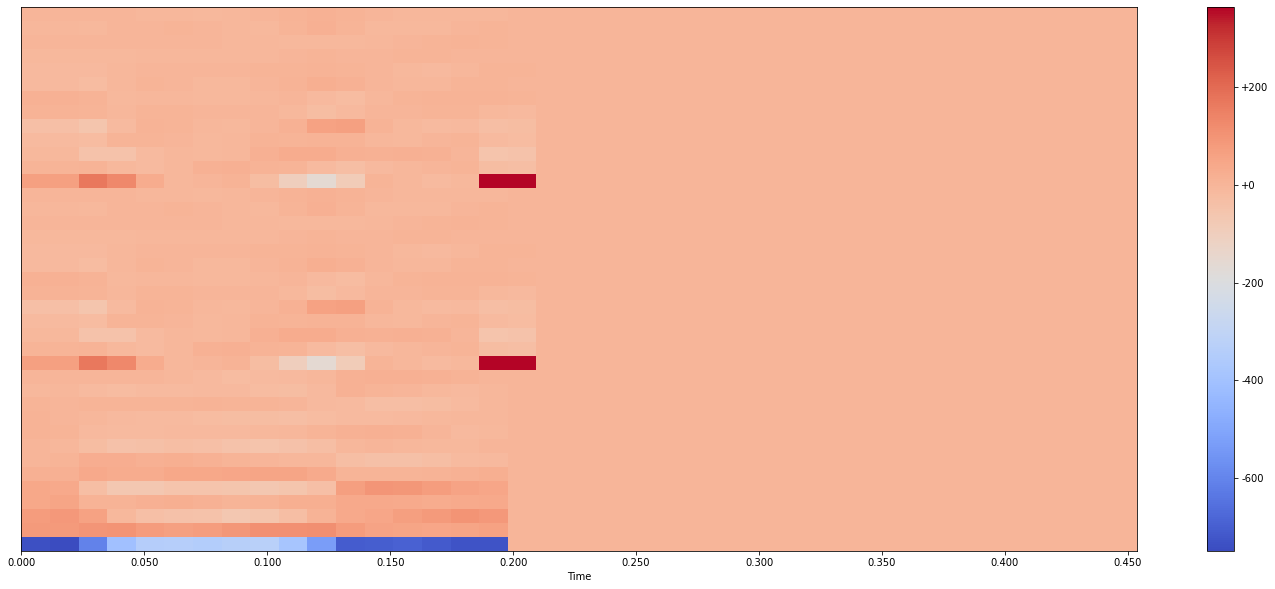

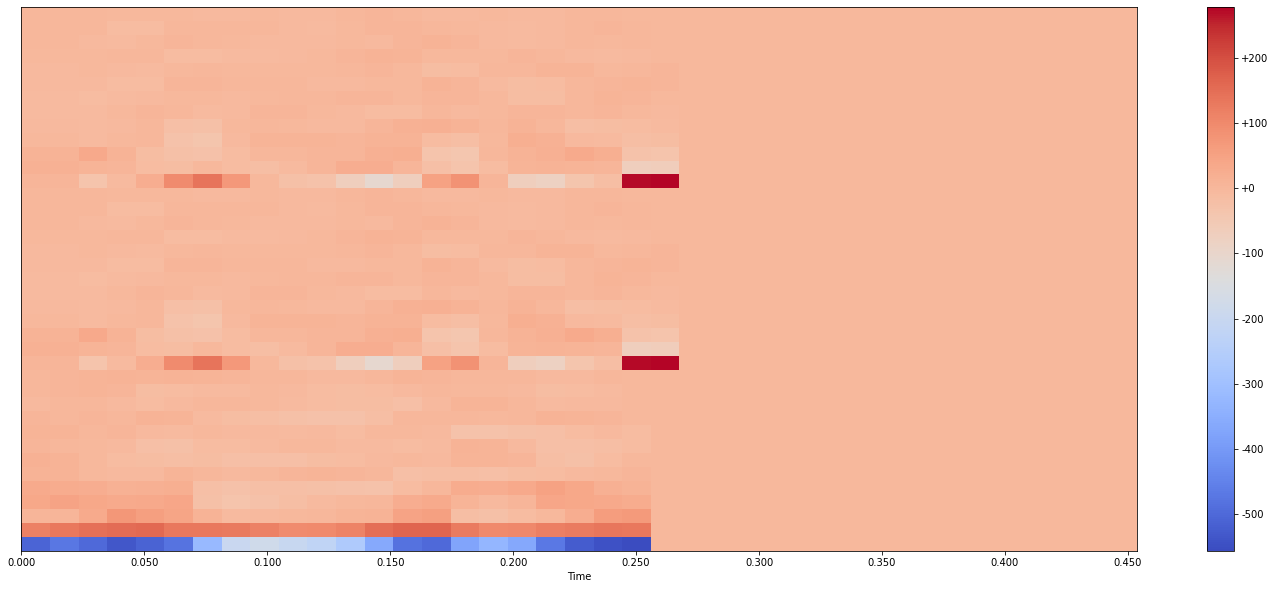

In [9]:
from librosa import display

# showing how mfcc for number '1' looks like

for i in range(200):
    if int(y_train[i]) == 1:
        plt.figure(figsize=(25, 10))
        librosa.display.specshow(X_train[i], 
                                 x_axis="time", 
                                 sr=44000)
        plt.colorbar(format="%+2.f")
        plt.show()

In [11]:
# one shot hot
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [14]:
# Feature dimension #

channels= 1
pool_size  = (2, 2) 
kernel_size= (3, 3)  

num_classes = len(labels)


# reshaping mfcc to feed into our model #

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], channels)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], channels)
X_val   = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], channels)

input_shape = (X_train.shape[1], X_train.shape[2], channels)

keras.backend.clear_session()

# model architecture #

model = keras.models.Sequential()
model.add(Conv2D(32, kernel_size, padding="same", input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))

# 1st layer
model.add(Conv2D(48, kernel_size, padding="same", kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(BatchNormalization())
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=pool_size))
    
# 2nd layer
model.add(Conv2D(64, kernel_size, padding="same", kernel_regularizer=keras.regularizers.l2(l=0.1)))
model.add(BatchNormalization())
model.add(Activation("relu"))  
model.add(MaxPooling2D(pool_size=pool_size))

# 3rd layer
model.add(Conv2D(128, kernel_size, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))  

# flatten and dense layer
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))

# output layer
model.add(Dense(num_classes, activation="softmax"))

# model compile
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=Adam(lr=.0001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 39, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 39, 39, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 39, 39, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 48)        13872     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 19, 48)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 19, 19, 48)        0

C:\Users\REVE\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
model.fit(X_train, y_train_hot, epochs=200, batch_size=64, validation_data=(X_val, y_val_hot))

Epoch 1/200
113/113 [==============================] - 19s 165ms/step - loss: 0.2662 - accuracy: 0.9857 - val_loss: 1.4296 - val_accuracy: 0.7084
Epoch 2/200
113/113 [==============================] - 18s 160ms/step - loss: 0.2670 - accuracy: 0.9841 - val_loss: 1.8938 - val_accuracy: 0.6145
Epoch 3/200
113/113 [==============================] - 19s 164ms/step - loss: 0.2557 - accuracy: 0.9872 - val_loss: 1.6358 - val_accuracy: 0.6746
Epoch 4/200
113/113 [==============================] - 18s 159ms/step - loss: 0.2467 - accuracy: 0.9891 - val_loss: 1.3619 - val_accuracy: 0.7309
Epoch 5/200
113/113 [==============================] - 18s 159ms/step - loss: 0.2444 - accuracy: 0.9872 - val_loss: 1.5595 - val_accuracy: 0.6884
Epoch 6/200
113/113 [==============================] - 17s 151ms/step - loss: 0.2496 - accuracy: 0.9865 - val_loss: 1.5360 - val_accuracy: 0.6683
Epoch 7/200
113/113 [==============================] - 18s 156ms/step - loss: 0.2506 - accuracy: 0.9853 - val_loss: 1.4414 -

In [17]:
model.evaluate(X_test, y_test_hot, verbose=1)

63/63 [==============================] - 1s 21ms/step - loss: 1.2332 - accuracy: 0.7782


[1.2332206964492798, 0.7781672477722168]

In [18]:
model.save('%_on_100_class_CNN.h5')

In [23]:
# evaluate trained models
# find precision, recall, f1 score

num_classes = 100 # no. of classes
model.load_weights('%_on_100_class_CNN.h5') # load trained model


def maxNumber(arr) : # find index of max number in array
    mx = 0
    mxIndx = -1
    for indx, val in enumerate(arr):
        if val > mx:
            mx = val
            mxIndx = indx
    return mxIndx




total = []    # total sample in each class
pos_reg = []  # number of positive samples in each class
fal_reg = []  # number of failed samples in each class

for i in range(num_classes): # initializing
    total.append(0)
    pos_reg.append(0)
    fal_reg.append(0)


pred = model.predict(X_test) # predict on the test set

for indx, res in enumerate(pred) :

    target = int(y_test[indx])
    
    total[target] += 1
    
    if target == maxNumber(res) :
        pos_reg[target] += 1
    
    else:
        fal_reg[maxNumber(res)] += 1


s1 = 0 
s2 = 0 
s3 = 0
for i in range(num_classes):
    s1 += pos_reg[i]
    s2 += total[i]
    s3 += fal_reg[i]

print("Precision, Recall, F1-score on test dataset")
print("precision: ", s1/(s1+s3)," recall: ", s1/s2, "f1 score :", (2*(s1/(s1+s3)))*(s1/s2)/((s1/(s1+s3))+(s1/s2)))


print("Precision, Recall, F1-score on each class of test dataset")
for i in range(num_classes):
    print(i, ": ", (pos_reg[i] / total[i] * 100), "  precision : ", pos_reg[i]/(pos_reg[i]+fal_reg[i]), " recall : ", pos_reg[i]/total[i], " f1score: ", (2*(pos_reg[i]/(pos_reg[i]+fal_reg[i]))*(pos_reg[i]/total[i]))/((pos_reg[i]/(pos_reg[i]+fal_reg[i]))+(pos_reg[i]/total[i])))

Precision, Recall, F1-score on test dataset
precision:  0.7781672508763144  recall:  0.7781672508763144 f1 score : 0.7781672508763144
Precision, Recall, F1-score on each class of test dataset
0 :  89.47368421052632   precision :  0.7391304347826086  recall :  0.8947368421052632  f1score:  0.8095238095238095
1 :  100.0   precision :  0.9166666666666666  recall :  1.0  f1score:  0.9565217391304348
2 :  90.0   precision :  0.75  recall :  0.9  f1score:  0.8181818181818182
3 :  92.3076923076923   precision :  0.7058823529411765  recall :  0.9230769230769231  f1score:  0.8000000000000002
4 :  76.47058823529412   precision :  0.9285714285714286  recall :  0.7647058823529411  f1score:  0.8387096774193549
5 :  86.66666666666667   precision :  0.6842105263157895  recall :  0.8666666666666667  f1score:  0.7647058823529413
6 :  83.33333333333334   precision :  0.9523809523809523  recall :  0.8333333333333334  f1score:  0.888888888888889
7 :  75.0   precision :  0.5454545454545454  recall :  0.75 